In [1]:
import os
import shutil
import random
from glob import glob
from natsort import natsorted

import numpy as np

import matplotlib.pyplot as plt

import nibabel as nib

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from tqdm import tqdm

from monai.data import DataLoader, Dataset, CacheDataset, pad_list_data_collate
from monai.utils import set_determinism
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    Spacingd,
    ToTensord,
    SpatialCropd,
    RandAdjustContrastd,
    RandGaussianNoised,
    RandCoarseShuffled,
    CropForegroundd,
    ResizeWithPadOrCropd
)

In [2]:
!nvidia-smi


NVIDIA-SMI has failed because you do not have suffient permissions. Please try running as an administrator.


In [3]:
torch.cuda.empty_cache()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )
device

device(type='cpu')

In [5]:
class RelabelTransform(MapTransform):
    def __init__(self, keys, old_label, new_label):
        super().__init__(keys)
        self.old_label = old_label
        self.new_label = new_label

    def __call__(self, data):

        d = dict(data)

        for key in self.keys:
            d[key][d[key] == self.old_label] = self.new_label
        return d



def prepare(
            in_dir,
            pixdim=(1.2, 1.2,1.0),
            spatial_size=[160, 160, 128],
            gamma=(0.5,0.8),
            roi_center=[100,100,79],
            roi_size =[160, 160, 128],
            cache=True,
            start_file=0,
            end_file=None,
            train_size=0.8):

    set_determinism(seed=0)

    flair = natsorted(glob(os.path.join(in_dir, '*/*flair.nii')))[start_file : end_file]
    t1 = natsorted(glob(os.path.join(in_dir, '*/*t1.nii')))[start_file : end_file]
    t1ce = natsorted(glob(os.path.join(in_dir, '*/*t1ce.nii')))[start_file : end_file]
    t2 = natsorted(glob(os.path.join(in_dir, '*/*t2.nii')))[start_file : end_file]
    mask = natsorted(glob(os.path.join(in_dir, '*/*seg.nii')))[start_file : end_file]

    full_dataset = [{"vol": [flair,t1ce,t2,t1], "seg": mask} for flair,t1ce,t2,t1,mask in
                   zip(flair,t1ce,t2,t1,mask)]


    # test_transform = Compose(
    #     [
    #                 LoadImaged(keys=["vol", "seg"]),
    #                 EnsureChannelFirstd(keys=["vol", "seg"]),
    #                 EnsureTyped(keys=["vol", "seg"]),

    #                 Orientationd(keys=["vol", "seg"], axcodes="RAS"),
    #                 # Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
    #                 RelabelTransform(keys=["seg"], old_label=4, new_label=3),

    #                 # Your augmentations
    #                 RandCoarseShuffled(
    #                     keys=["vol"],
    #                     prob=0.6,
    #                     holes=6,
    #                     spatial_size=(12, 12, 12)
    #                 ),
    #                 RandGaussianNoised(keys=["vol"], prob=0.7, mean=0.2, std=0.5),
    
    #                 # # ⛑️ Add shape correction here
    #                 ResizeWithPadOrCropd(keys=["vol", "seg"], spatial_size=(240, 240, 150)),

    #                 # Optional: normalization
    #                 NormalizeIntensityd(keys="vol", nonzero=True, channel_wise=True),
    #     ]
    # )
    
    test_transform = Compose(
        [
                LoadImaged(keys=["vol", "seg"]),
                EnsureChannelFirstd(keys=["vol", "seg"]),
                EnsureTyped(keys=["vol", "seg"]),

                Orientationd(keys=["vol", "seg"], axcodes="RAS"),
                Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
                RelabelTransform(keys=["seg"], old_label=4, new_label=3),
                SpatialCropd(keys=["vol","seg"], roi_center=roi_center ,roi_size=roi_size ),

                RandGaussianNoised(keys=["vol"], prob=0.6, mean=0.0, std=0.1),
                NormalizeIntensityd(keys="vol", nonzero=True, channel_wise=True),

        ]
    )


    if cache:
        test_ds = CacheDataset(
            data=full_dataset,
            transform=test_transform,
            cache_rate=1.0,
            num_workers=0,
        )



        return (
    DataLoader(test_ds, batch_size=2, shuffle=True, num_workers=0)
)


    else:
        test_ds = Dataset(
                    data=full_dataset,
                    transform=test_transform,
                    cache_rate=1.0,
                    num_workers=0,
                )

        return (
    DataLoader(test_ds, batch_size=2, shuffle=True, num_workers=0)
)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetEncoder, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.pool = nn.MaxPool3d(2, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        skip = x
        x = self.pool(x)
        return x, skip


class UNetDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDecoder, self).__init__()
        self.upconv = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv3d(out_channels * 2, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x


class UNetBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetBottleneck, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.dropout = nn.Dropout3d(0.3)  # %30 dropout

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        return x


class UnetModel(nn.Module):
    def __init__(self, num_classes):
        super(UnetModel, self).__init__()

        self.encoder1 = UNetEncoder(4, 32)
        self.encoder2 = UNetEncoder(32, 64)
        self.encoder3 = UNetEncoder(64, 128)
        self.encoder4 = UNetEncoder(128, 256)

        self.bottleneck = UNetBottleneck(256, 512)

        self.decoder1 = UNetDecoder(512, 256)
        self.decoder2 = UNetDecoder(256, 128)
        self.decoder3 = UNetDecoder(128, 64)
        self.decoder4 = UNetDecoder(64, 32)

        self.final_conv = nn.Conv3d(32, num_classes, kernel_size=1)

    def forward(self, x):
        x, skip1 = self.encoder1(x)
        x, skip2 = self.encoder2(x)
        x, skip3 = self.encoder3(x)
        x, skip4 = self.encoder4(x)

        x = self.bottleneck(x)

        x = self.decoder1(x, skip4)
        x = self.decoder2(x, skip3)
        x = self.decoder3(x, skip2)
        x = self.decoder4(x, skip1)

        x = self.final_conv(x)
        return x

In [7]:
model = UnetModel(4).to(device)

In [8]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.smooth = smooth

    def dice_loss(self, pred, target):
        pred = torch.softmax(pred, dim=1)
        intersection = (pred * target).sum(dim=(2, 3, 4))
        union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

    def forward(self, pred, target):
        dice = self.dice_loss(pred, target)
        ce = nn.CrossEntropyLoss()(pred, target.argmax(dim=1))  # [B, 128, 128, 128]
        return self.alpha * dice + (1 - self.alpha) * ce

In [9]:
print(next(model.parameters()).device)  # Should print cuda:0


cpu


In [10]:
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model architecture
model = UnetModel(4)  # Replace with your model class\\
checkpoint_path = r"D:\web dev backup\Pytorch\Brain_tumor\unet_model_v01_refactored.pth"
# model.load_state_dict(torch.load(r"D:\web dev backup\Pytorch\Brain_tumor\unet_model_v5.pth"))

if os.path.exists(checkpoint_path):
      print(f"Loading previous checkpoint from {checkpoint_path}...")
      checkpoint = torch.load(checkpoint_path, map_location=device)

      if 'best_dice' in checkpoint and checkpoint['best_dice'] is not None:
          best_dice = checkpoint['best_dice']
          print(f"Loaded best Dice score from checkpoint: {best_dice:.4f}")
      else:
          best_dice = 0.0
          print("No best Dice score found in checkpoint. Using default value of 0.0.")

      model.load_state_dict(checkpoint['model_state_dict'])
      print("Checkpoint loaded successfully!")
else:
      print("No checkpoint found. Starting training from scratch.")
      
model.to(device)
model.eval()
print("Model loaded successfully!")

Loading previous checkpoint from D:\web dev backup\Pytorch\Brain_tumor\unet_model_v01_refactored.pth...
Loaded best Dice score from checkpoint: 0.3552
Checkpoint loaded successfully!
Model loaded successfully!


In [11]:
test_path = r"G:\BraTS\MICCAI_BraTS2020_TestingData"
test_loader = prepare(in_dir=test_path,start_file=0,end_file=100,train_size=0.9)

Loading dataset: 100%|██████████| 15/15 [00:27<00:00,  1.80s/it]


In [12]:
import numpy as np
import matplotlib.pyplot as plt

def dice_coefficient(pred, target, smooth=1e-6):
    pred = torch.softmax(pred, dim=1)  # [B, 4, 128, 128, 128]
    intersection = (pred * target).sum(dim=(2, 3, 4))
    union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def visualize_prediction(image, mask, prediction):
    # print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)
    print(mask.max())
    # # print("Prediction shape:", prediction.shape)
    # mask = nib.load(mask).get_fdata().astype(np.uint8)
    
    # mask = mask[mask == 4] = 3
    
    plt.figure(figsize=(12, 4))

    # Visualizing one of the channels (e.g., FLAIR)
    for i in range(60,72,3):
        flair_slice = image[0, 0, :, :, i].cpu().numpy()  # Taking a middle slice from FLAIR channel
        mask_slice = mask[0, 0, :, :, i].cpu().numpy()    # Middle slice of ground truth mask
        pred_slice = prediction[0, :, :, i]               # Middle slice of predicted mask
        
        plt.subplot(1, 3, 1)
        plt.imshow(flair_slice, cmap='gray')  # Display FLAIR channel
        plt.title("FLAIR")

        plt.subplot(1, 3, 2)
        plt.imshow(mask_slice, cmap='viridis')
        plt.colormaps()
        plt.colorbar()
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_slice, cmap='viridis')
        plt.colormaps()
        plt.colorbar()
        plt.title("Prediction")

        plt.show()

torch.Size([2, 4, 160, 160, 128])
torch.Size([2, 1, 160, 160, 128])
metatensor(3.5023)
Sample 1: Dice Coefficient = 0.2690
Mask shape: torch.Size([2, 1, 160, 160, 128])
metatensor(3.)


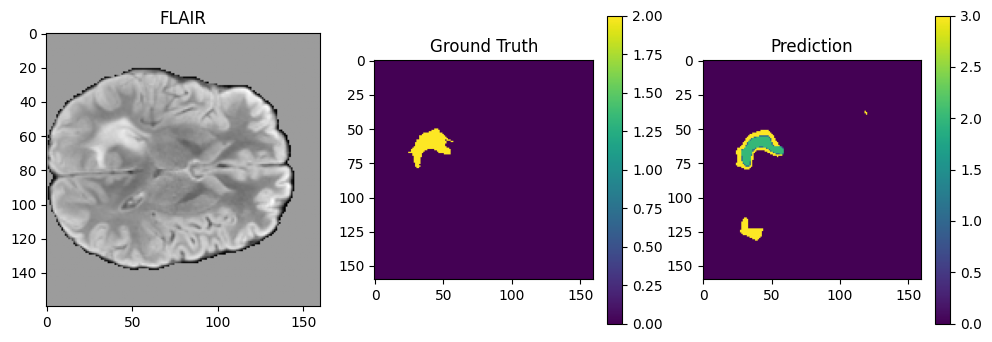

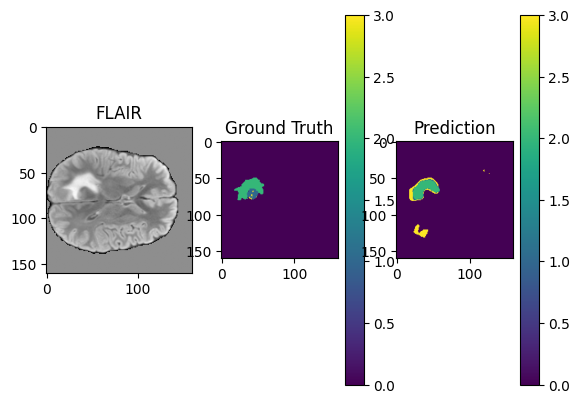

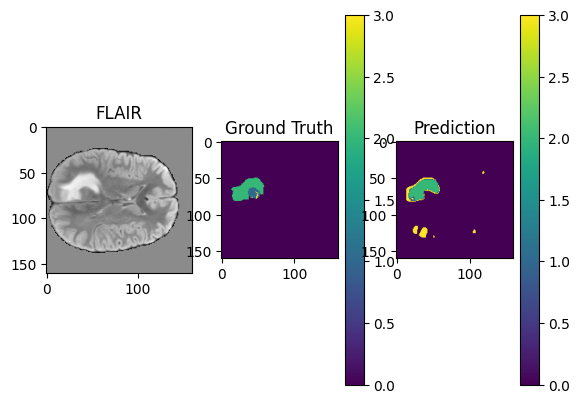

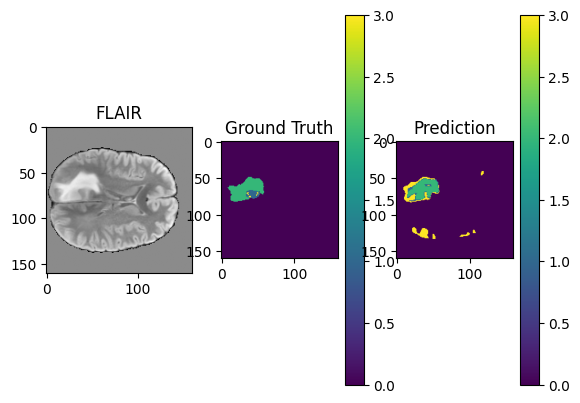

torch.Size([2, 4, 160, 160, 128])
torch.Size([2, 1, 160, 160, 128])
metatensor(3.7002)
Sample 2: Dice Coefficient = 0.3031
Mask shape: torch.Size([2, 1, 160, 160, 128])
metatensor(3.)


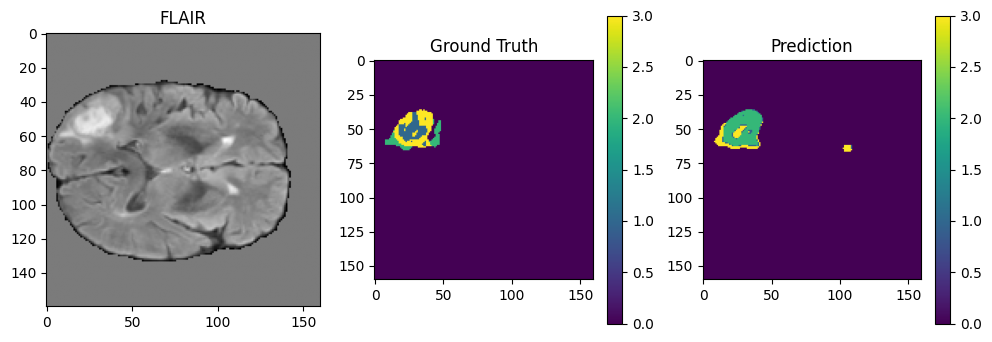

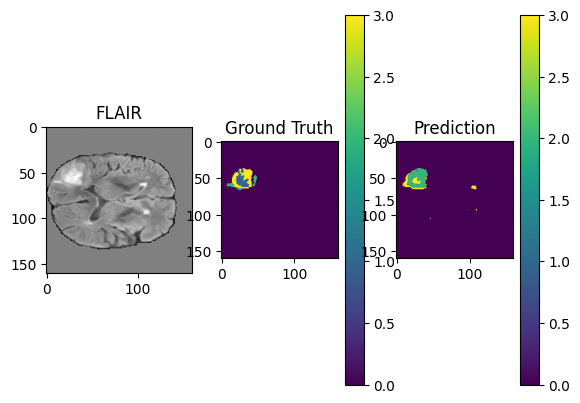

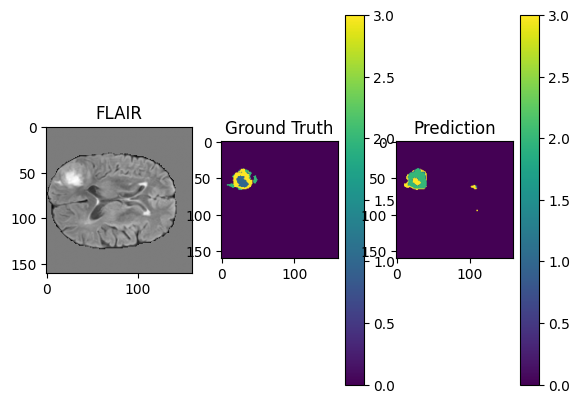

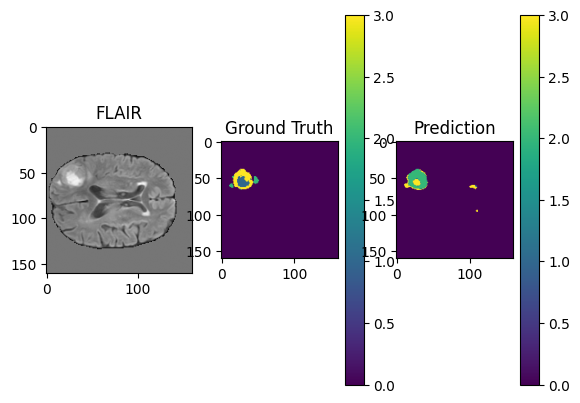

torch.Size([2, 4, 160, 160, 128])
torch.Size([2, 1, 160, 160, 128])
metatensor(3.8202)
Sample 3: Dice Coefficient = 0.3257
Mask shape: torch.Size([2, 1, 160, 160, 128])
metatensor(3.)


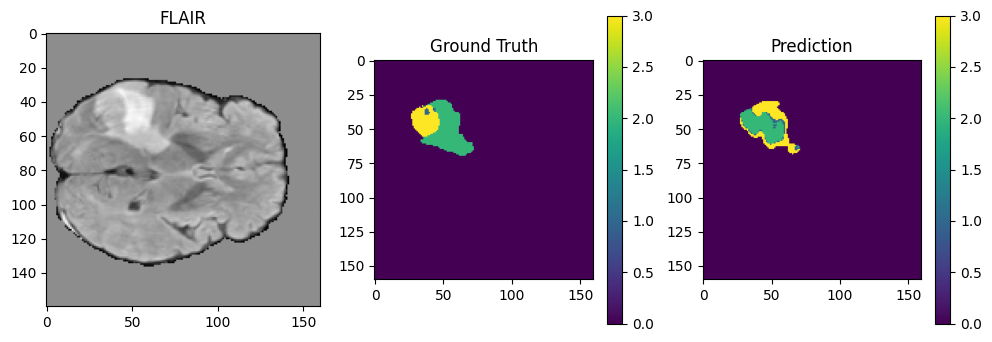

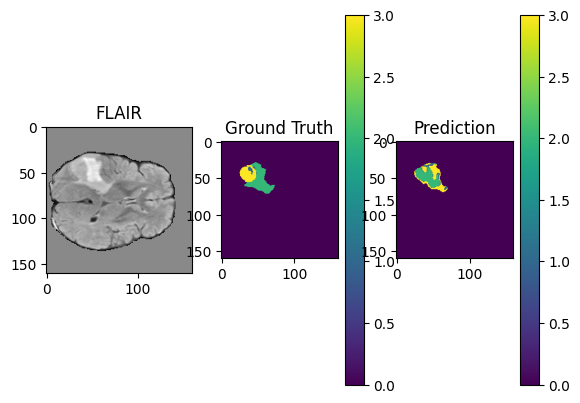

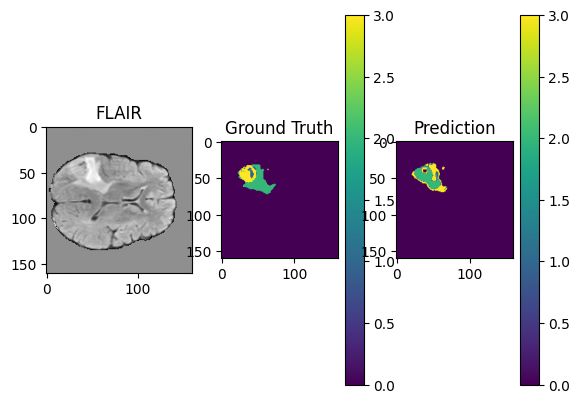

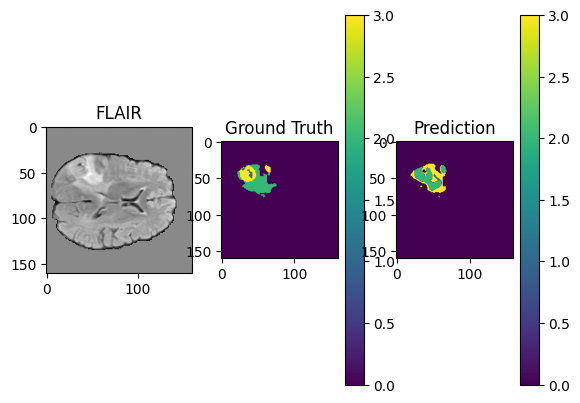

torch.Size([2, 4, 160, 160, 128])
torch.Size([2, 1, 160, 160, 128])
metatensor(3.9911)
Sample 4: Dice Coefficient = 0.3445
Mask shape: torch.Size([2, 1, 160, 160, 128])
metatensor(3.)


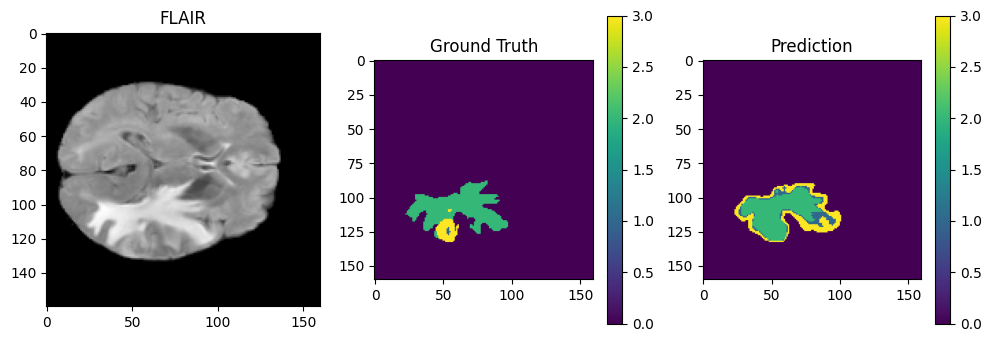

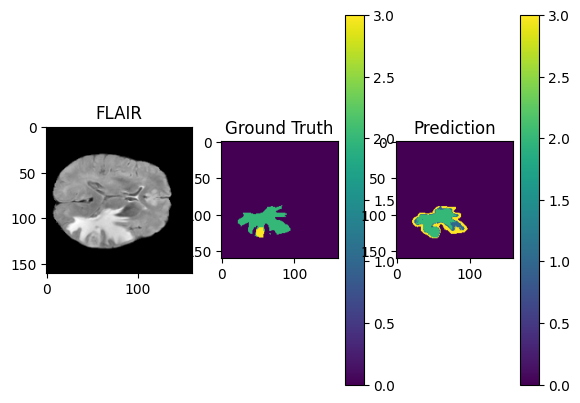

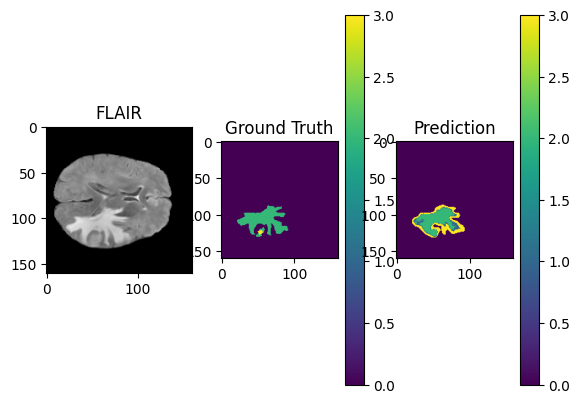

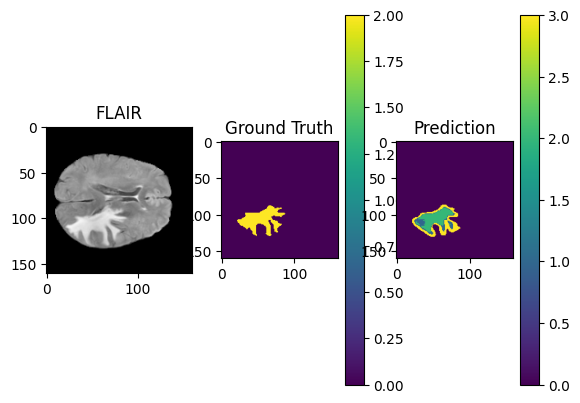

torch.Size([2, 4, 160, 160, 128])
torch.Size([2, 1, 160, 160, 128])
metatensor(3.4138)
Sample 5: Dice Coefficient = 0.3324
Mask shape: torch.Size([2, 1, 160, 160, 128])
metatensor(3.)


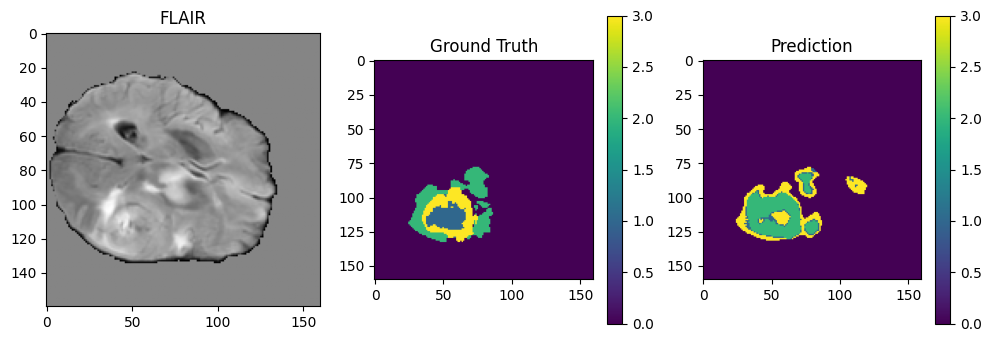

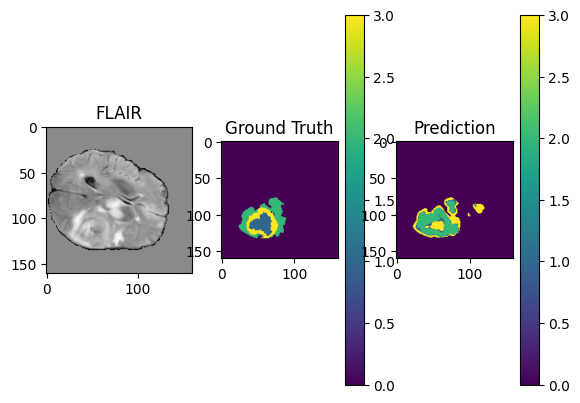

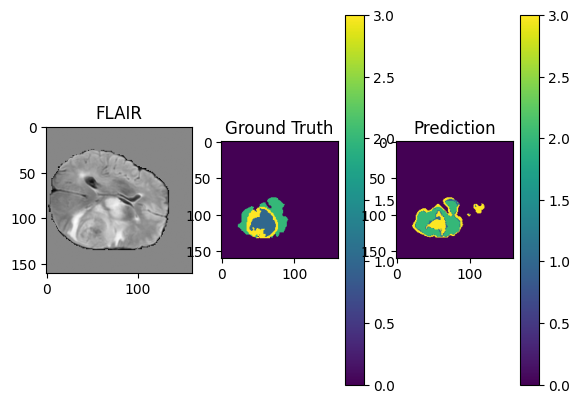

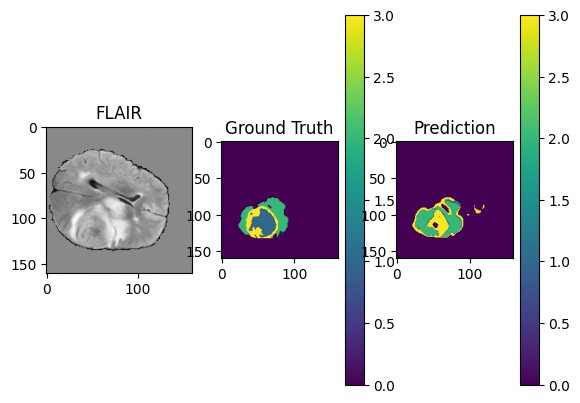

torch.Size([2, 4, 160, 160, 128])
torch.Size([2, 1, 160, 160, 128])
metatensor(3.6488)
Sample 6: Dice Coefficient = 0.3361
Mask shape: torch.Size([2, 1, 160, 160, 128])
metatensor(3.)


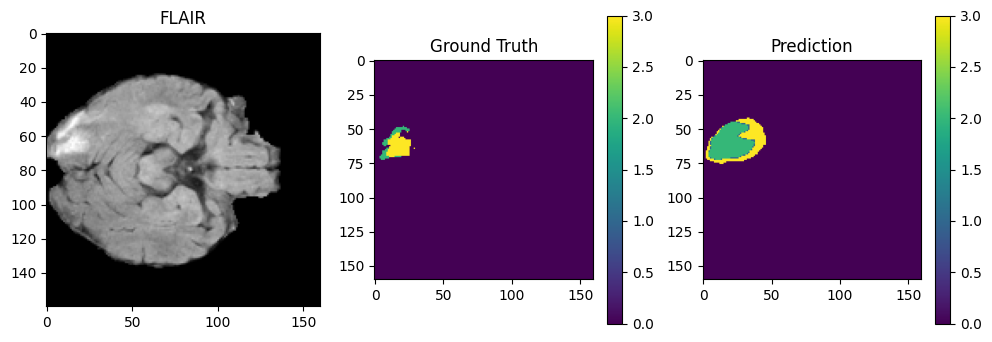

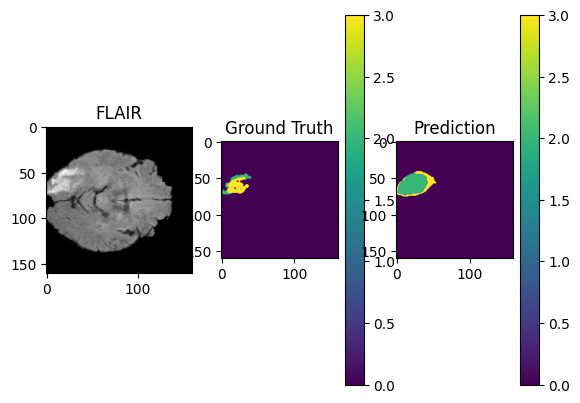

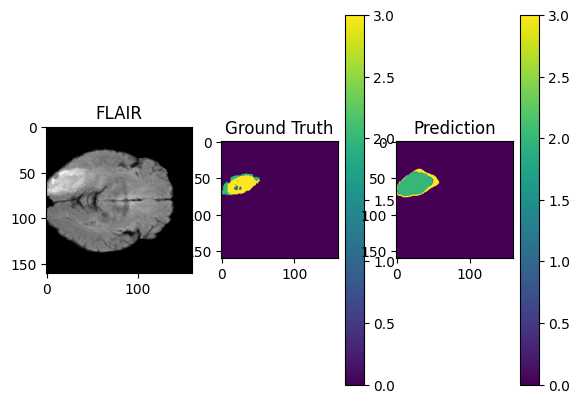

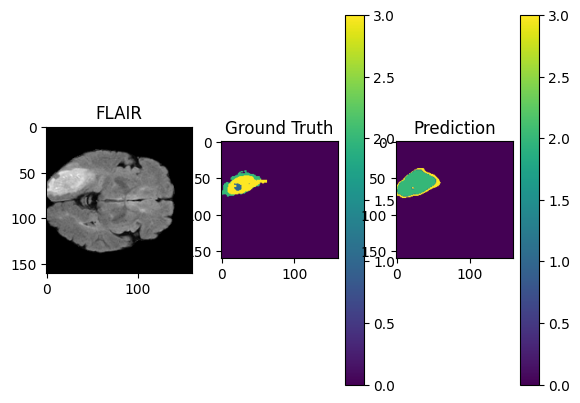

torch.Size([2, 4, 160, 160, 128])
torch.Size([2, 1, 160, 160, 128])
metatensor(3.9979)
Sample 7: Dice Coefficient = 0.3524
Mask shape: torch.Size([2, 1, 160, 160, 128])
metatensor(3.)


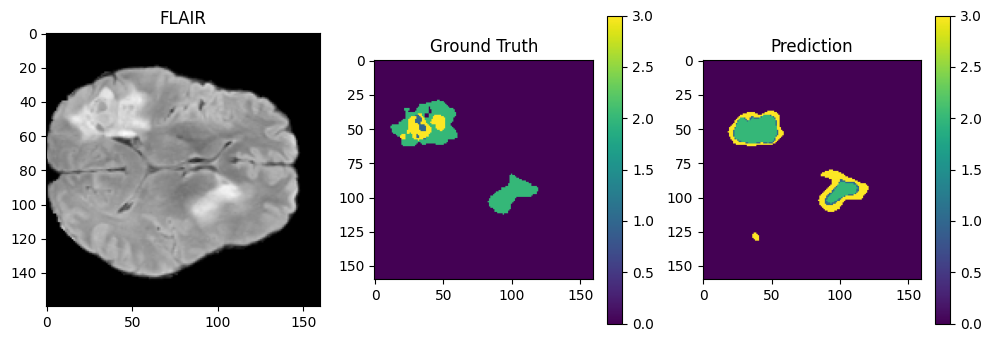

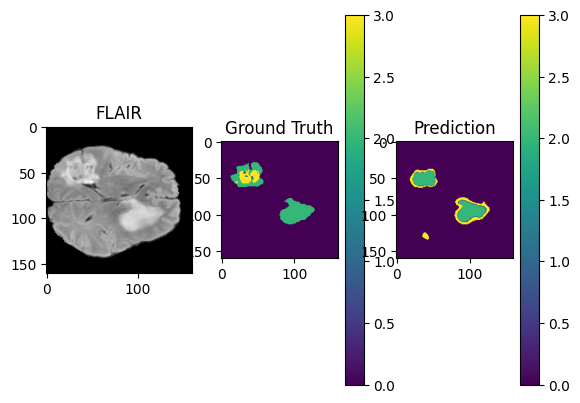

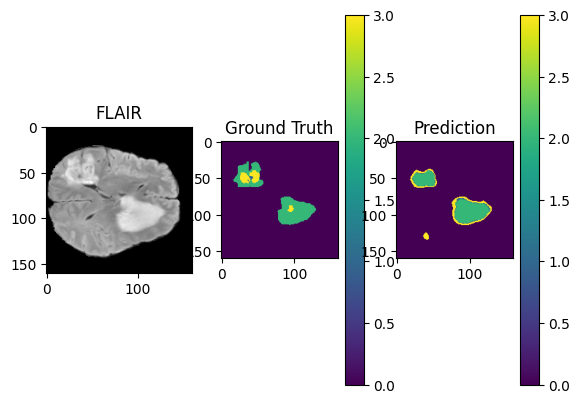

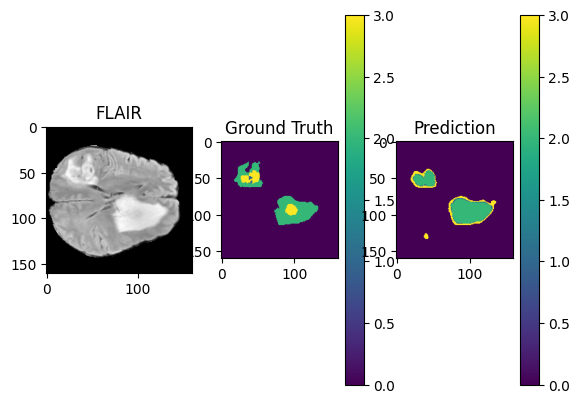

torch.Size([1, 4, 160, 160, 128])
torch.Size([1, 1, 160, 160, 128])
metatensor(3.4135)
Sample 8: Dice Coefficient = 0.3254
Mask shape: torch.Size([1, 1, 160, 160, 128])
metatensor(3.)


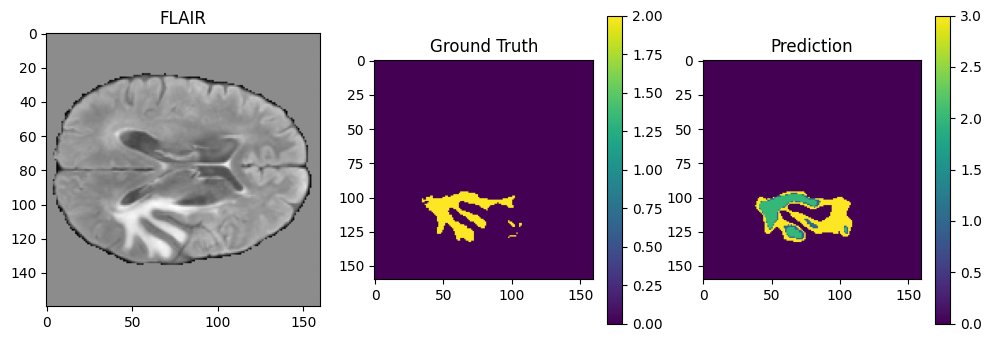

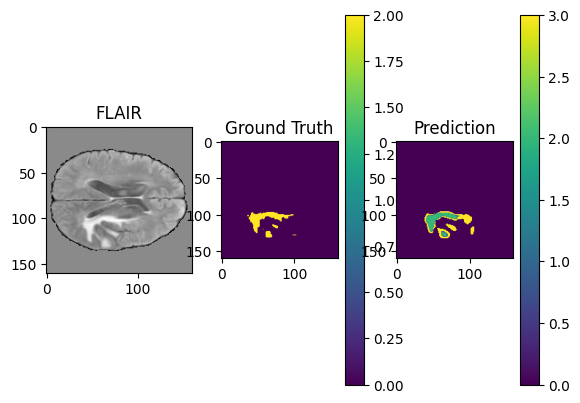

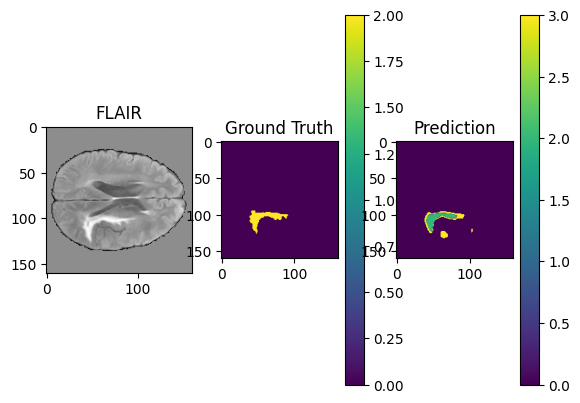

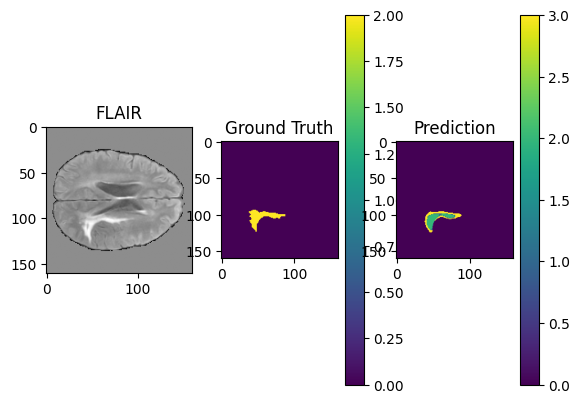

Average Dice Coefficient: 0.3236


In [13]:
model.eval()
total_dice = 0
num_samples = 0

with torch.no_grad():
        for  batch_idx,batch_data in enumerate(test_loader):


                image, mask = batch_data['vol'], batch_data['seg']
                image, mask = image.to(device), mask.to(device)
        
                # print(np.unique(mask).cpu)
                # plt.imshow(mask.cpu().numpy()[0,0,:,:,64])
                
                print(image.shape)
                print(mask.shape)

                # Forward pass
                output = model(image)

                # Calculate Dice coefficient
                dice = dice_coefficient(output, mask)
                total_dice += dice
                num_samples += 1

                # Convert predictions to class labels for visualization
                print(output.max())
                predicted_mask = torch.argmax(output, dim=1).cpu().numpy()
                # print(predicted_mask.shape)

                print(f"Sample {batch_idx + 1}: Dice Coefficient = {dice:.4f}")

                # Visualize the result (for first few samples)
                
                visualize_prediction(image, mask, predicted_mask)

print(f"Average Dice Coefficient: {total_dice / num_samples:.4f}")
